<a href="https://colab.research.google.com/github/mshreeharsha/HuBMAP---Hacking-the-Human-Vasculature-FA-Major-Project/blob/main/benchMarking/HuBMAP_Hacking_the_Human_Vasculature_FA_Major_Project_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#Paths to files
basePath = "/content/drive/MyDrive/HuBMAP_Hacking_the_Human_Vasculature"
imagesFolder = basePath + "/train/"
labelsPath = basePath + "/polygons.jsonl"

In [30]:
import torch
from torch.utils.data import Dataset
import json
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [31]:
class LabelDataset(Dataset):
    def __init__(self, labelsPath, imagePath):
        self.labelsDataset = self.getLabelDataset(labelsPath)
        self.labelsPath = labelsPath
        self.imagePath = imagePath

    def getLabelDataset(self, labelsPath):
        with open(labelsPath) as jsonFile:
            jsonList = list(jsonFile)

        labelsDataset = []
        for jsonStr in jsonList:
            result = json.loads(jsonStr)
            # result -> {id:"", annotations:[]}
            annotations = result['annotations']

            for ann in annotations:
                if ann["type"] != "blood_vessel":
                    continue
                row = {
                    "id": result["id"],
                    "coordinates": ann["coordinates"],
                }
                labelsDataset.append(row)

        return pd.DataFrame(labelsDataset, columns=["id", "coordinates"])

    def generateMask(self, imageID):
        mask = np.zeros((512, 512, 1), dtype=np.uint8)
        annotations = self.labelsDataset[self.labelsDataset['id'] == imageID]
        for _, row in annotations.iterrows():
            coordinates = np.array(row["coordinates"])
            mask = cv2.fillPoly(mask, [coordinates], 1)
        return mask

    def __len__(self):
        return len(self.labelsDataset['id'].unique())

    def __getitem__(self, index):
        uniqueIDs = self.labelsDataset['id'].unique()
        imgID = uniqueIDs[index]
        imagePath = f"{self.imagePath}/{imgID}.tif"
        image = cv2.imread(imagePath, cv2.COLOR_BGR2RGB)
        mask = self.generateMask(imageID=imgID)

        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)

        #Numpy array to tensors
        # mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        image = np.array(image) / 255.0
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        return image,mask,imgID


In [32]:
labels = LabelDataset(labelsPath,imagesFolder)
print(f"Number of ID-s removed, where 'blood_vessel' were missing: {1633-len(labels)}")

Number of ID-s removed, where 'blood_vessel' were missing: 11


In [33]:
testLen = int(0.2*len(labels))
lengths = [len(labels)-testLen, testLen]
trainSet, testSet = torch.utils.data.random_split(labels, lengths)

reducedTrainLen = int(0.5 * len(trainSet))
trainSet, _ = torch.utils.data.random_split(trainSet, [reducedTrainLen, len(trainSet) - reducedTrainLen])
print(f"train set: {len(trainSet)}, validation set: {len(testSet)}")

train set: 649, validation set: 324


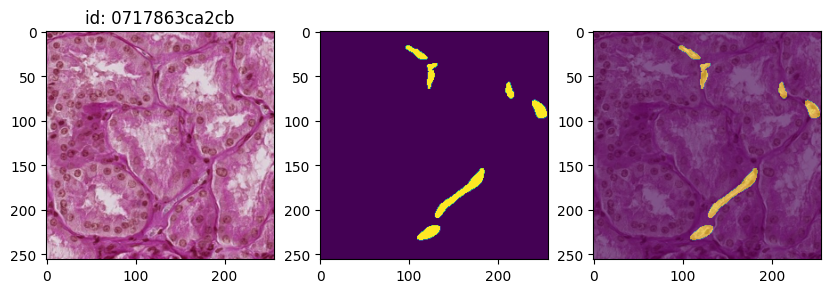

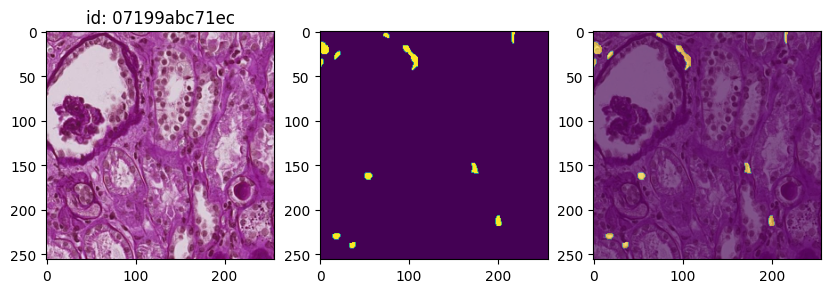

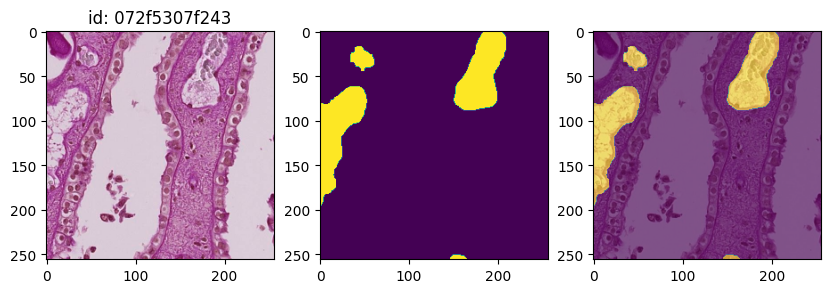

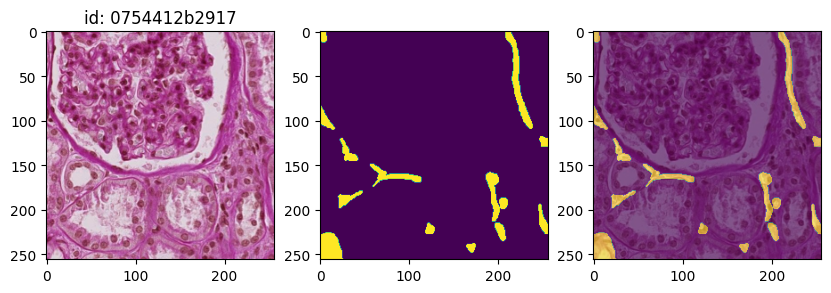

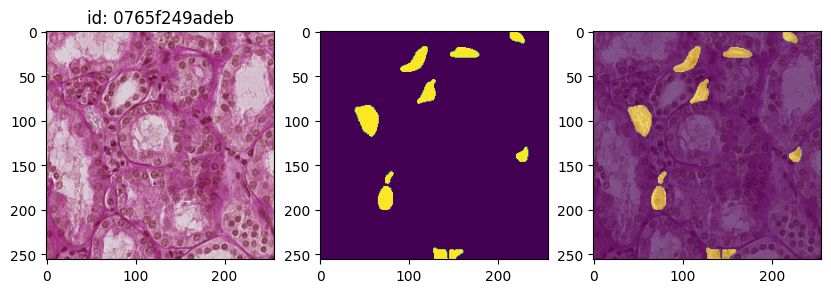

In [34]:
samples = [labels[i] for i in range(40,45)]

for sample in samples:
    masks = sample[1].squeeze(0)
    image = sample[0].permute(1,2,0).numpy()

    fig, axs = plt.subplots(1,3,figsize=(10,8))
    axs[0].imshow(image)
    axs[0].set_title(f"id: {sample[2]}")
    axs[1].imshow(masks)
    axs[2].imshow(image)
    axs[2].imshow(masks, alpha=0.6)
    plt.show()

In [ ]:
pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=42b1f2e243ab0a86f851cac68be476c58f819f5870c7a45786989852788d02fa
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=6a3b8743502cd69dc90c22af004d0e31f7c1b798d10e72cac13b2ee4b635f805
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [ ]:
pip install torchinfo

In [35]:
import segmentation_models_pytorch as smp
from torchinfo import summary
import torch.nn as nn
import torch.nn.functional as F
import keras
import keras.backend as K
from torch.utils.data import DataLoader
from datetime import datetime

In [36]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

In [37]:
summary(model, input_size=(1,3,256,256), col_names=['input_size','output_size','num_params','trainable'])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
Unet                                          [1, 3, 256, 256]          [1, 1, 256, 256]          --                        True
├─ResNetEncoder: 1-1                          [1, 3, 256, 256]          [1, 3, 256, 256]          --                        True
│    └─Conv2d: 2-1                            [1, 3, 256, 256]          [1, 64, 128, 128]         9,408                     True
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         [1, 64, 128, 128]         128                       True
│    └─ReLU: 2-3                              [1, 64, 128, 128]         [1, 64, 128, 128]         --                        --
│    └─MaxPool2d: 2-4                         [1, 64, 128, 128]         [1, 64, 64, 64]           --                        --
│    └─Sequential: 2-5                        [1, 64, 64, 64]           [1, 64, 64, 64]         

In [38]:
class config:
    imgSize = 256
    inChannel = 3
    numClasses = 1
    batchSize = 16
    initLR = 1e-3
    weightDecay = 1e-4
    epochs = 10

In [39]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [40]:
#Train Loader
trainLoader = DataLoader(trainSet, batch_size=config.batchSize, shuffle=True)

In [41]:
#Statistics
def calculateStatistics(labels, preds):
    predClass = torch.sigmoid(preds).round()
    numOfCorrect = (predClass == labels).sum().item()
    numOfPixels = labels.numel()

    intersection = (predClass * labels).sum().item()
    union = (predClass + labels).sum().item() - intersection

    if union > 0:
        pixel_acc = numOfCorrect / numOfPixels * 100
        iou = intersection / union * 100
        dice_score = (2 * intersection) / ((predClass + labels).sum().item() + 1e-8)
    else:
        pixel_acc = 0
        iou = 0
        dice_score = 0

    return dice_score, iou, pixel_acc

In [42]:
def saveCheckpoint(model, optimizer, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"Checkpoint saved at epoch {epoch}, loss: {loss:.4f}, path: {path}")


In [43]:
modelSavePath = "/content/drive/MyDrive/HuBMAP_Hacking_the_Human_Vasculature/training/model.pt"

In [46]:
#Training Loop Func
def training(trainLoader, model, lossFunc, optimizer, totalEpochs, startEpoch, device="cuda"):
    history = {
        "epoch": [],
        "train_loss": [],
        "diceScore": [],
        "iou": [],
        "pixelAcc": [],
    }

    for e in range(startEpoch,totalEpochs):
        model.train()
        print("-" * 40)
        print(f"EPOCH {e + 1}/{totalEpochs}. training step...")

        trainTimeStart = datetime.now()
        lossList = []
        totalDiceScores = 0
        totalIOU = 0
        totalPixelAcc = 0

        for i, data in enumerate(trainLoader):
            image = data[0].to(device)
            segGroundTruth = data[1].to(device)

            # Forward pass
            segPred = model(image)
            loss = lossFunc(segPred, segGroundTruth)

            # Backward pass and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            lossList.append(loss.item())

            diceScore, iou, pixelAcc = calculateStatistics(labels=segGroundTruth, preds=segPred)
            totalDiceScores += diceScore
            totalIOU += iou
            totalPixelAcc += pixelAcc

        avgTrainLoss = np.mean(lossList)
        avgDiceScores = totalDiceScores / len(trainLoader)
        avgIOU = totalIOU / len(trainLoader)
        avgPixelAcc = totalPixelAcc / len(trainLoader)

        train_time_end = datetime.now() - trainTimeStart
        print(f" - Train epoch mean loss: {avgTrainLoss:.4f}")
        print(f" - Dice score: {avgDiceScores:.4f}")
        print(f" - IoU: {avgIOU:.2f}%")
        print(f" - Pixel accuracy: {avgPixelAcc:.2f}%")
        print(f" - Epoch training time: {train_time_end}\n")

        history["epoch"].append(e + 1)
        history["train_loss"].append(avgTrainLoss)
        history["diceScore"].append(avgDiceScores)
        history["iou"].append(avgIOU)
        history["pixelAcc"].append(avgPixelAcc)

        saveCheckpoint(model, optimizer, e, avgTrainLoss, modelSavePath)

    return history

In [47]:
lossFunc = DiceBCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.initLR, weight_decay=config.weightDecay)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
history = training(trainLoader, model, lossFunc, optimizer, config.epochs,0,device)

----------------------------------------
EPOCH 1/10. training step...
 - Train epoch mean loss: 1.2062
 - Dice score: 0.0527
 - IoU: 2.92%
 - Pixel accuracy: 92.06%
 - Epoch training time: 0:05:03.221086

Checkpoint saved at epoch 0, loss: 1.2062, path: /content/drive/MyDrive/HuBMAP_Hacking_the_Human_Vasculature/training/model.pt
----------------------------------------
EPOCH 2/10. training step...
 - Train epoch mean loss: 0.8415
 - Dice score: 0.4325
 - IoU: 27.83%
 - Pixel accuracy: 94.94%
 - Epoch training time: 0:00:21.288893

Checkpoint saved at epoch 1, loss: 0.8415, path: /content/drive/MyDrive/HuBMAP_Hacking_the_Human_Vasculature/training/model.pt
----------------------------------------
EPOCH 3/10. training step...
 - Train epoch mean loss: 0.6991
 - Dice score: 0.5079
 - IoU: 34.42%
 - Pixel accuracy: 95.68%
 - Epoch training time: 0:00:20.994530

Checkpoint saved at epoch 2, loss: 0.6991, path: /content/drive/MyDrive/HuBMAP_Hacking_the_Human_Vasculature/training/model.pt
--

In [ ]:
def loadCheckpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    print(f"Checkpoint loaded from epoch {epoch}, loss: {loss:.4f}")

    return model, optimizer, epoch, loss


In [ ]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)
lossFunc = DiceBCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.initLR, weight_decay=config.weightDecay)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the checkpoint
model, optimizer, startEpoch, lastLoss = loadCheckpoint(model, optimizer, modelSavePath)

history = training(trainLoader, model, lossFunc, optimizer, config.epochs,startEpoch+1,device)

